In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm
import seaborn as sns

In [3]:
#Проблемы классификации выживаемости, связанные с конкретными пассажирами

from xgboost import XGBClassifier

In [4]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')
y_data = pd.read_csv('titanic/gender_submission.csv')

In [5]:
#Проверка данных
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
#Проверка данных
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
#Проверка данных
y_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [8]:
print(train.shape, test.shape, y_data.shape)

(891, 12) (418, 11) (418, 2)


In [9]:
#Исключите признаки, которые на ваш взгляд, могут привести к переобучению (например, id)
#Разделите выборку на train и test.
test.drop(labels=['Ticket' , 'PassengerId' , 'Name' , 'Cabin'], axis=1 , inplace = True)
train.drop(labels=['Ticket' , 'PassengerId', 'Name', 'Cabin'], axis=1 , inplace = True)

Преобразуйте категориальные признаки 

#pd.get_dummies
#реобразовываем категориальные переменные в фиктивные переменные, 
#которые представляют собой числовые переменные, используемые для представления категориальных данных.
train = pd.get_dummies(train , columns=['Sex'] , prefix='Sex')
train = pd.get_dummies(train , columns=['Embarked'] , prefix='Embarked')
test = pd.get_dummies(test , columns=['Sex'] , prefix='Sex')
test = pd.get_dummies(test , columns=['Embarked'] , prefix='Embarked')
train.head()

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [11]:
train_copy = train[set(train.columns.tolist())-{'PassengerId', 'Name', 'Cabin','Survived', 'Ticket'}].copy(deep=True)
test_copy = test[set(test.columns.tolist())-{'PassengerId', 'Name','Survived', 'Cabin', 'Ticket'}].copy(deep=True)

C:\Users\Ilsiyar\AppData\Local\Temp\ipykernel_11052\3060151419.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_copy = train[set(train.columns.tolist())-{'PassengerId', 'Name', 'Cabin','Survived', 'Ticket'}].copy(deep=True)
C:\Users\Ilsiyar\AppData\Local\Temp\ipykernel_11052\3060151419.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  test_copy = test[set(test.columns.tolist())-{'PassengerId', 'Name','Survived', 'Cabin', 'Ticket'}].copy(deep=True)


In [12]:
#Label Encoding
#Если есть вероятность, что в обучающих данных могут отсутствовать категориальные особенности, 
#часто бывает лучше указать, handle_unknown='ignore'
le_sex, le_emb = LabelEncoder(), LabelEncoder()
le_sex.fit(list(set(train['Sex'].tolist())))
le_emb.fit(list(set(train['Embarked'].tolist())))
train_copy['Sex'] = le_sex.transform(train_copy['Sex'].astype(str))
train_copy['Embarked'] = le_emb.transform(train_copy['Embarked'].astype(str))
test_copy['Sex'] = le_sex.transform(test_copy['Sex'].astype(str))
test_copy['Embarked'] = le_emb.transform(test_copy['Embarked'].astype(str))


train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [13]:
#One-Hot Encoding
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [5,6])], remainder='passthrough')
ct.fit(train_copy)
train_copy_ = np.array(ct.transform(train_copy))
test_copy_ = np.array(ct.transform(test_copy))
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


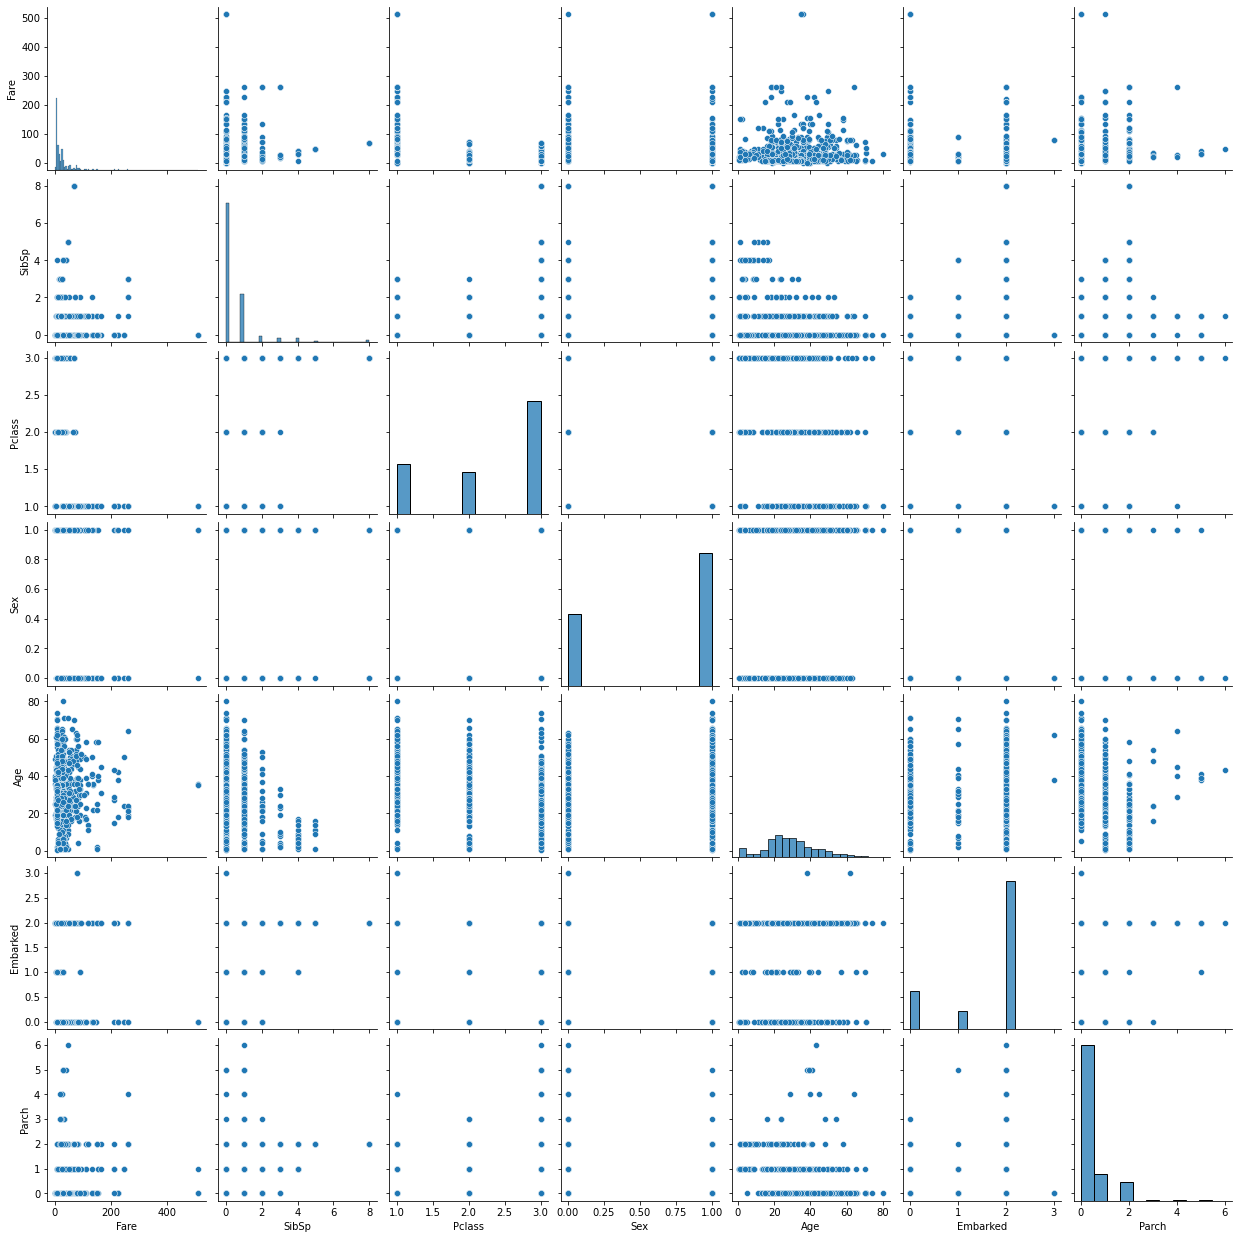

In [14]:
sns.pairplot(train_copy)

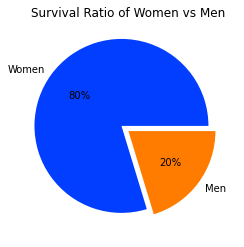

In [15]:
import matplotlib.pyplot as plt

women = train[train['Sex']=='female']['Survived'].tolist()
rate_women = sum(women)/len(women)

men = train[train['Sex']=='male']['Survived'].tolist()
rate_men = sum(men)/len(men)
  
# declaring data
data = [rate_women, rate_men]
keys = ['Women', 'Men']
  
# declaring exploding pie
explode = [0.1, 0]
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')
  
# plotting data on chart
plt.pie(data, labels=keys, colors=palette_color,
        explode=explode, autopct='%.0f%%')
plt.title("Survival Ratio of Women vs Men")
# displaying chart
plt.show()

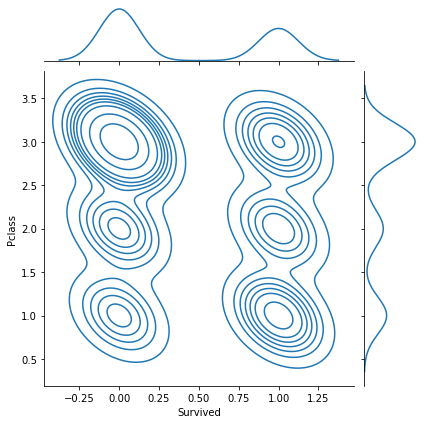

In [16]:
sns.jointplot(x ='Survived', y ='Pclass', data = train[['Pclass', 'Survived']], kind ='kde')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Pclass'>

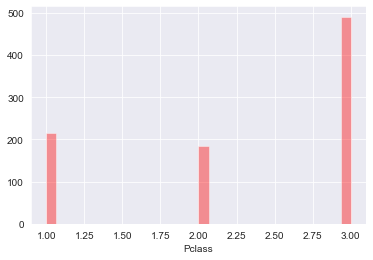

In [17]:
sns.set_style('darkgrid')
sns.distplot(train['Pclass'], kde = False, color ='red', bins = 30)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

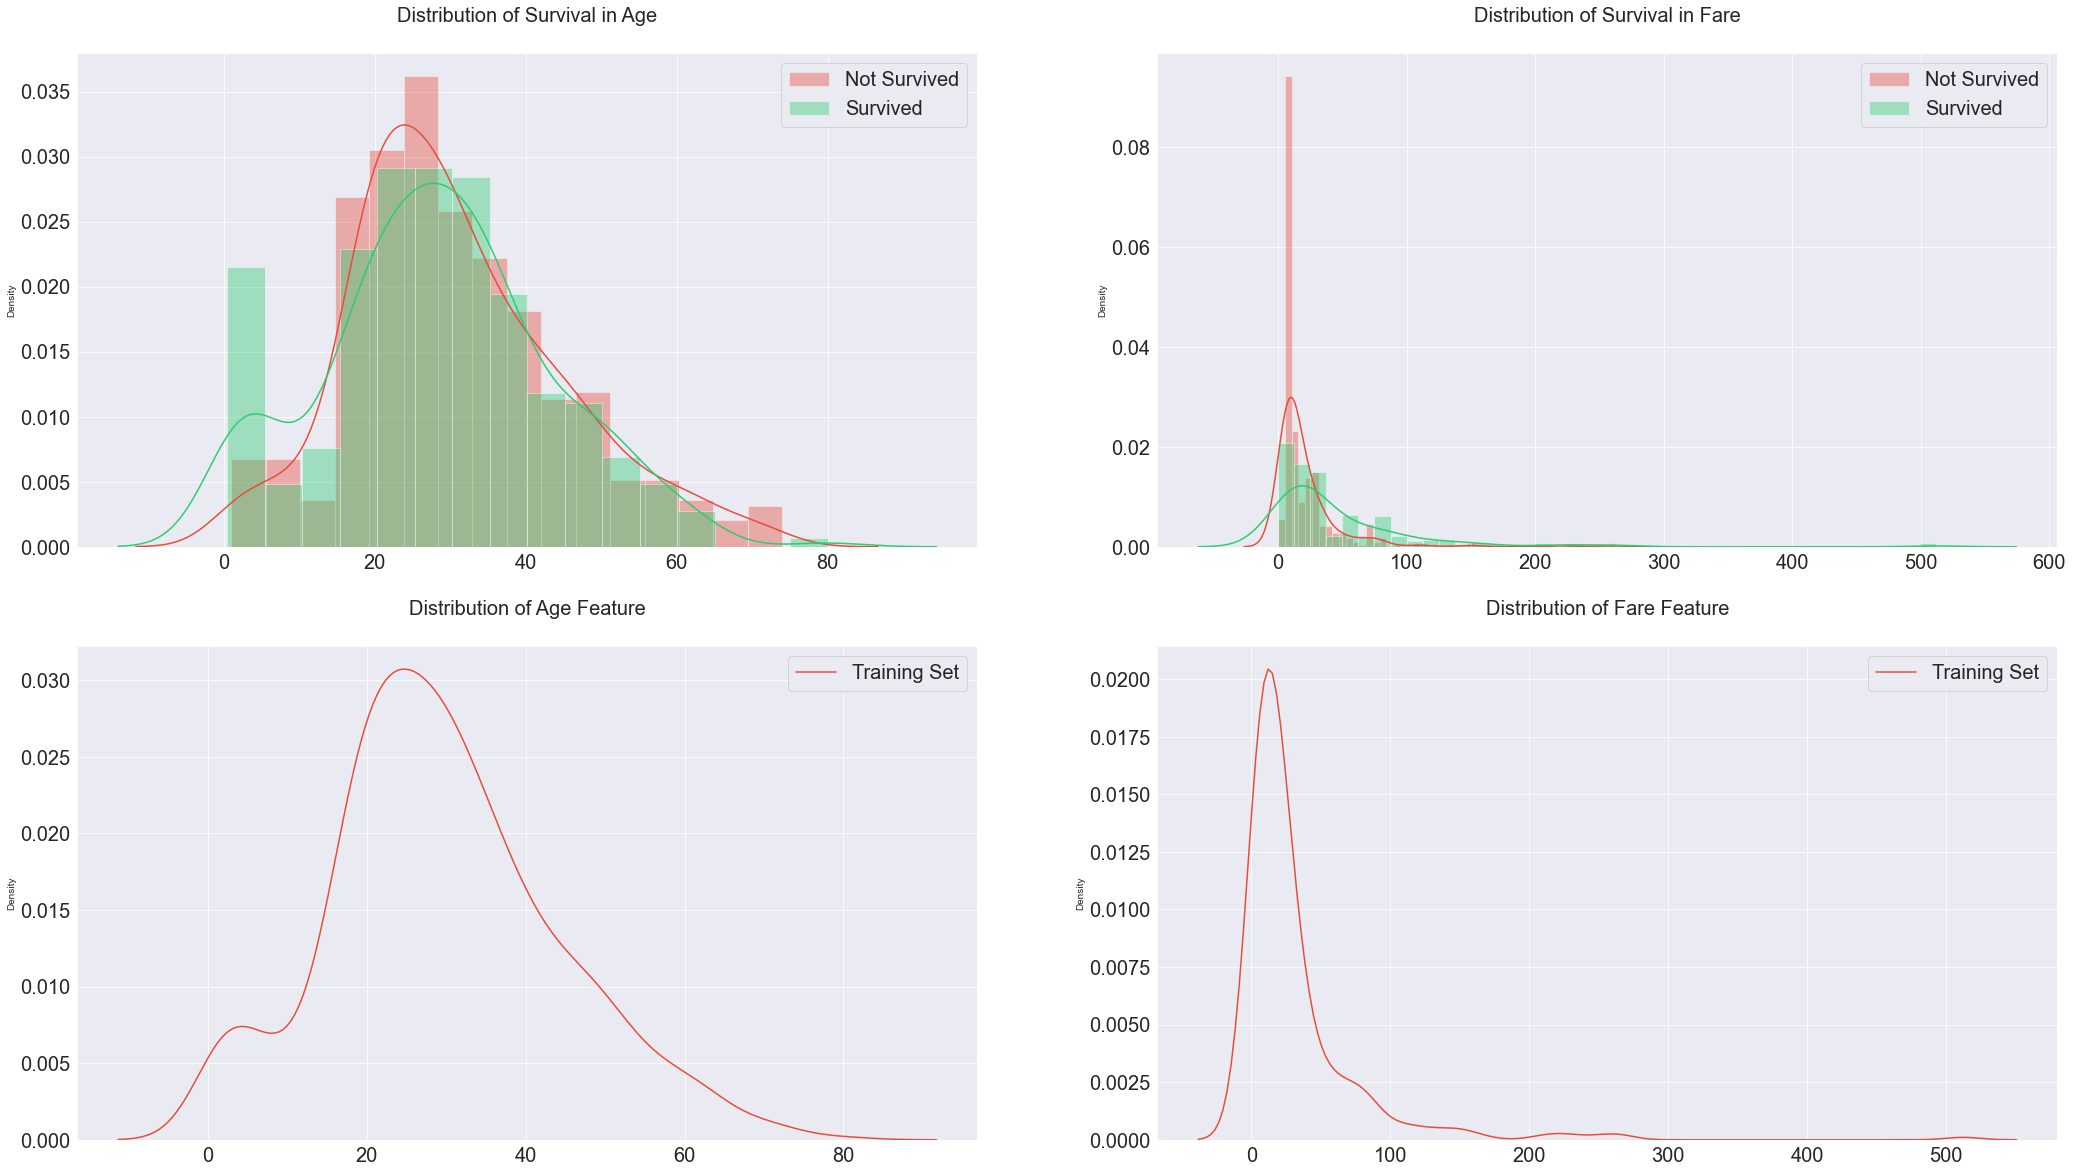

In [18]:
cont_features = ['Age', 'Fare']
surv = train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

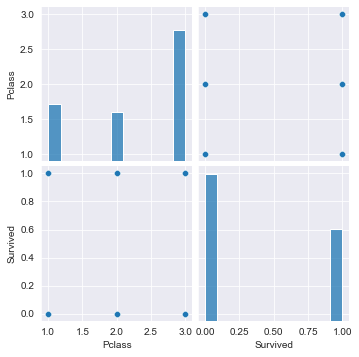

In [19]:
sns.pairplot(train[['Pclass', 'Survived']])

Преобразуйте категориальные признаки с помощью 
sklearn.preprocessing.StandardScaler 

In [20]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(train_copy_)

StandardScaler()

1)Обучите модели логистической регрессии и KNN, 
2)посчитайте все метрики классификации, которые были упомянуты на занятии, 
сделайте выводы

In [21]:
# 1)import the KNNimputer class
from sklearn.impute import KNNImputer

In [22]:
X = train.loc[:, train.columns != 'Survived']
y = train['Survived']

In [23]:
#Data Impution (KNN)
imputer = KNNImputer(n_neighbors=5)
imputer.fit(train_copy_)

KNNImputer()

In [24]:
train_copy_= imputer.transform(train_copy_)

In [25]:
#2) Вычисление метрик с перекрестной проверкой cross_val_score
DT = svm.SVC(random_state=2343)
cross_val_score(DT, train_copy_, y, cv=10).mean()

0.6779775280898876

# 2) Вычисление метрик DecisionTreeClassifier - осуществляет мультиклассовую классификацию набора данных
DecisionTreeClassifier принимает в качестве входных данных два массива: массив X, разреженный или плотный, формы (n_samples, n_features), содержащий обучающие образцы, и массив Y целочисленных значений, формы (n_samples,), содержащий метки классов для обучающих образцов

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
DT1 = DecisionTreeClassifier(random_state=2343, criterion = 'entropy' , max_depth = 6 , min_samples_split=5)
cross_val_score(DT1, train_copy_, y, cv=10).mean()

0.8160174781523096

Подберите гиперпараметры для обоих моделей с помощью 
RandomizedSearchCV, 
напишите, почему, как вы думаете, эти параметры подошли.

Train test split

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


In [29]:
!pip install lazypredict

Defaulting to user installation because normal site-packages is not writeable


In [30]:
from lazypredict.Supervised import LazyClassifier #предназначенная для сравнения производительности различных
#моделей машинного обучения в наборе данных
clf = LazyClassifier(verbose=0,ignore_warnings=False, custom_metric=None)
models, predictions = clf.fit(x_train, x_test, y_train, y_test)

 31%|█████████████████████████▊                                                         | 9/29 [00:00<00:00, 24.33it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 76%|██████████████████████████████████████████████████████████████▏                   | 22/29 [00:00<00:00, 27.29it/s]

StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 13.27it/s]


Text(0.5, 1.0, 'models based on Accuracy')

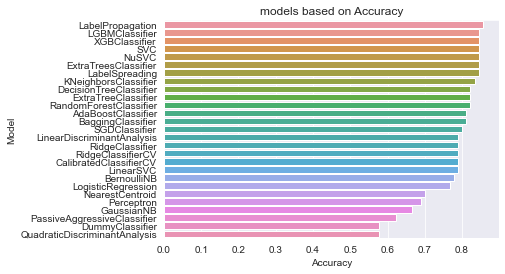

In [31]:
#Lazy model evaluation
temp_df = models.sort_values('Accuracy', ascending = False)
sns.barplot(x = temp_df['Accuracy'], y = temp_df.index).set_title('models based on Accuracy')
#Визуализация результатов ранжируется на основе наилучшего результата

In [32]:
import lightgbm as lgb
lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(train_copy_,y)

LGBMClassifier()

In [33]:
#Прогноз по представленным данным
preds_lgb_model = lgb_clf.predict(sc.transform(test_copy_))

In [ ]:
#вывод по Прогнозу по представленным данным
output = pd.DataFrame({'PassengerId': test_copy.PassengerId, 'Survived': preds_lgb_model})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
#найти осталось мне в чем ошибка в верзней команде

In [34]:
#help block Преобразовать 
#pd.get_dummies
#реобразовываем категориальные переменные в фиктивные переменные, 
#которые представляют собой числовые переменные, используемые для представления категориальных данных.
train = pd.get_dummies(train , columns=['Sex'] , prefix='Sex')
train = pd.get_dummies(train , columns=['Embarked'] , prefix='Embarked')
test= pd.get_dummies(test , columns=['Sex'] , prefix='Sex')
test = pd.get_dummies(test , columns=['Embarked'] , prefix='Embarked')
#One-Hot Encoding
#ct1 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [5,6])], remainder='passthrough')
#ct1.fit(train_copy)
#train_copy = np.array(ct1.transform(train_copy))
#train.head()

In [35]:
#Best Model
best_model = DecisionTreeClassifier(random_state=2343, criterion = 'entropy' , max_depth = 6 , min_samples_split=5)
#cross_val_score(best_model, train_copy_, y, cv=10).mean()
X.fillna(cross_val_score(best_model, train, y, cv=10).mean())
best_model.fit(X, y)
data_testP  = pd.read_csv('titanic/test.csv')
pred = best_model.predict(test)
df_pred = pd.DataFrame(pred , columns=['Survived'])
df_pred['PassengerId'] = data_testP['PassengerId']
df_pred.head()

ValueError: could not convert string to float: 'male'

In [ ]:
#найти осталось мне в чем ошибка в верзней команде

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X.mean(), y)#y train
clf.predict(x_test)